# Centralized CIFAR10 Baseline

A centralized CIFAR10 baseline experiment using a simple network for comparison
purposes with FLoES functionality.

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
class CIFARModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(32 * 28 * 28, 128)
        self.fc2 = torch.nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)

In [4]:
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = CIFARModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

model = model.to(device)
model.train()
accs = []
test_losses = []

print(device)

# number of epochs
with tqdm(range(200), unit='epochs') as tepochs:
    for i in tepochs:
        
        # epoch
        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # testing
        model.eval()
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += criterion(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size

        # update
        accs.append(correct * 100.)
        test_losses.append(test_loss)
        tepochs.set_postfix_str(f'Last accuracy: {correct:.3f}')

cuda


100%|██████████| 200/200 [1:02:36<00:00, 18.78s/epochs, Last accuracy: 0.621]


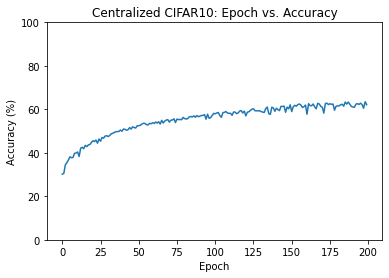

Final Accuracy: 62.13
Best Accuracy: 63.48 at Epoch: 198.


In [9]:
import matplotlib.pyplot as plt
import pickle
with open('accs.pkl', 'wb') as f:
    pickle.dump(accs, f)
plt.figure()
plt.plot(accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim([0, 100])
plt.title("Centralized CIFAR10: Epoch vs. Accuracy")
plt.show()
print(f'Final Accuracy: {accs[-1]:.2f}')
import numpy
print(f'Best Accuracy: {max(accs):.2f} at Epoch: {numpy.argmax(accs)}.')

In [7]:
import torch
torch.save(model, 'cifarmodel_200.pt')